In [ ]:
!pip3 install pygad
# !pip3 install pytorch
import pygad
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy
# import torch
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
tf.get_logger().setLevel(logging.ERROR)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.6 MB/s eta 0:00:00


In [ ]:
# 載入訓練資料集(cap loss)
data_train_cl = pd.read_csv(
    "/content/data/cl.csv",
    names=["fsw", "cap", "ind", "pl_c"])


# 訓練資料集格式
data_features_cl = data_train_cl.copy()
data_labels_cl = data_features_cl.pop('pl_c')
# print(data_features['fsw'])
# print(data_features['cap'])
data_features_cl = np.array(data_features_cl)
# type(data_features)
# print(data_features.shape)
# print(data_features)
print(data_labels_cl)

# 載入訓練資料集(inductor loss)
data_train_indl = pd.read_csv(
    "/content/data/indl.csv",
    names=["fsw", "cap", "ind", "pl_i_cu"])


# 訓練資料集格式
data_features_indl = data_train_indl.copy()
data_labels_indl = data_features_indl.pop('pl_i_cu')

data_features_indl = np.array(data_features_indl)

# 載入訓練資料集(ripple)
data_train_ripple = pd.read_csv(
    "/content/data/ripple.csv",
    names=["fsw", "cap", "ind", "ripple"])


# 訓練資料集格式
data_features_ripple = data_train_ripple.copy()
data_labels_ripple = data_features_ripple.pop('ripple')

data_features_ripple = np.array(data_features_ripple)

# 載入訓練資料集(ripple)
data_train_ripple = pd.read_csv(
    "/content/data/ripple.csv",
    names=["fsw", "cap", "ind", "ripple_v", "ripple_c"])


# 訓練資料集格式
data_features_ripple = data_train_ripple.copy()
data_labels_ripple_v = data_features_ripple.pop('ripple_v')
data_labels_ripple_c = data_features_ripple.pop('ripple_c')
data_features_ripple = np.array(data_features_ripple)


# 載入訓練資料集(switch loss)
data_train_sw = pd.read_csv(
    "/content/data/sw.csv",
    names=["fsw", "cap", "ind", "pl_sw_h", "pl_sw_l"])


# 訓練資料集格式
data_features_sw = data_train_sw.copy()
data_labels_sw_h = data_features_sw.pop('pl_sw_h')
data_labels_sw_l = data_features_sw.pop('pl_sw_l')
print(data_labels_sw_h)
print(data_labels_sw_l)

0      3.968110e-02
1      3.819260e-03
2      1.348250e-03
3      6.851580e-04
4      4.146880e-04
           ...     
120    2.650000e-06
121    2.560000e-07
122    9.040000e-08
123    4.590000e-08
124    1.040000e-05
Name: pl_c, Length: 125, dtype: float64
0      0.787592
1      1.694640
2      0.878606
3      0.838686
4      0.917525
         ...   
120    8.946420
121    8.893490
122    8.721900
123    8.599520
124    8.455230
Name: pl_sw_h, Length: 125, dtype: float64
0      0.296786
1      0.666378
2      0.291024
3      0.275003
4      0.292937
         ...   
120    0.477527
121    0.471485
122    0.475186
123    0.487756
124    0.485783
Name: pl_sw_l, Length: 125, dtype: float64


In [ ]:
# 權重初始化物件 (使用Random Uniform)
initializer1 = keras.initializers.RandomUniform(
    minval=-0.1, maxval=0.1)

initializer2 = keras.initializers.RandomUniform(
    minval=-0.1, maxval=0.1)

initializer3 = keras.initializers.RandomUniform(
    minval=-0.1, maxval=0.1)

initializer4 = keras.initializers.RandomUniform(
    minval=-0.1, maxval=0.1)
# 創建以下結構的序列式模型：
# 三個輸入變量 fs:開關頻率 L:電感值 C:電容值
# scalarization layer 將輸入變量縮放到[0,1]
# 三層密集(全連接)層,各含12,10,8個神經元
# 每層密集層後面接batch normalization層
# 隱藏層輸出函數使用tanh
# 輸出層直接輸出 a.losse of switch 兩個輸出神經元 b.inductor losses 兩個輸出神經元 c.capacitor loss 兩個輸出神經元 d.Ripples 一個輸出神經元
class ScalarizationLayer(keras.layers.Layer):
  def __init__(self, units, **kwargs):
        super().__init__()
        self.units = units
  def build(self, input_shape):
        # 创建独立的权重和偏置
        # fsw
        self.w_a = self.add_weight(name='w_a',
                                   shape=(input_shape[-1], self.units),
                                   initializer=keras.initializers.Constant(value=1./180e3),
                                   trainable=False)

        self.b_a = self.add_weight(name='b_a',
                                   shape=(self.units,),
                                   initializer=keras.initializers.Constant(value=-20e3),
                                   trainable=False)
        #cap value

        self.w_b = self.add_weight(name='w_b',
                                   shape=(input_shape[-1], self.units),
                                   initializer=keras.initializers.Constant(value=1./1970e-6),
                                   trainable=False)

        self.b_b = self.add_weight(name='b_b',
                                   shape=(self.units,),
                                   initializer=keras.initializers.Constant(value=-30e-6),
                                   trainable=False)
        #ind value

        self.w_c = self.add_weight(name='w_c',
                                   shape=(input_shape[-1], self.units),
                                   initializer=keras.initializers.Constant(value=1./980e-6),
                                   trainable=False)

        self.b_c = self.add_weight(name='b_c',
                                   shape=(self.units,),
                                   initializer=keras.initializers.Constant(value=-20e-6),
                                   trainable=False)

  def call(self, inputs):
      # 假设 inputs 是一个形状为 (batch_size, 3) 的张量
      a = inputs[:, 0:1]
      b = inputs[:, 1:2]
      c = inputs[:, 2:3]

      # 计算每个参数的输出
      output_a = tf.matmul(a + self.b_a, self.w_a)
      output_b = tf.matmul(b + self.b_b, self.w_b)
      output_c = tf.matmul(c + self.b_c, self.w_c)

      # 将输出拼接成一个张量
      output = tf.concat([output_a, output_b, output_c], axis=1)
      return output



model_cl = keras.Sequential([
   #scalarization layer
   ScalarizationLayer(3),
   #BN-NN layer 1 (10個神經元)
   keras.layers.Dense(12, activation='tanh',
                       kernel_initializer=initializer1,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #BN-NN layer 2 (10個神經元)
   keras.layers.Dense(10, activation='tanh',
                       kernel_initializer=initializer2,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #BN-NN layer 3 (8個神經元)
  #  keras.layers.Dense(8, activation='tanh',
  #                      kernel_initializer=initializer,
  #                      bias_initializer='zeros'),
  #  keras.layers.BatchNormalization(),
   #output layer (直接輸出)
   keras.layers.Dense(1, activation='relu',
                       kernel_initializer=initializer3,
                       bias_initializer='zeros')
])

model_ripple = keras.Sequential([
   #scalarization layer
   ScalarizationLayer(3),
   #BN-NN layer 1 (10個神經元)
   keras.layers.Dense(12, activation='tanh',
                       kernel_initializer=initializer1,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #BN-NN layer 2 (10個神經元)
   keras.layers.Dense(10, activation='tanh',
                       kernel_initializer=initializer2,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #BN-NN layer 3 (8個神經元)
  #  keras.layers.Dense(8, activation='tanh',
  #                      kernel_initializer=initializer,
  #                      bias_initializer='zeros'),
  #  keras.layers.BatchNormalization(),
   #output layer (直接輸出)
   keras.layers.Dense(2, activation='relu',
                       kernel_initializer=initializer3,
                       bias_initializer='zeros')
])

model_sw_h = keras.Sequential([
   #scalarization layer
   ScalarizationLayer(3),
   #BN-NN layer 1 (10個神經元)
   keras.layers.Dense(10, activation='tanh',
                       kernel_initializer=initializer1,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #BN-NN layer 2 (10個神經元)
   keras.layers.Dense(10, activation='tanh',
                       kernel_initializer=initializer2,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #BN-NN layer 3 (8個神經元)
   keras.layers.Dense(10, activation='tanh',
                       kernel_initializer=initializer3,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #output layer (直接輸出)
   keras.layers.Dense(1, activation='relu',
                       kernel_initializer=initializer4,
                       bias_initializer='zeros')
])

model_sw_l = keras.Sequential([
   #scalarization layer
   ScalarizationLayer(3),
   #BN-NN layer 1 (10個神經元)
   keras.layers.Dense(10, activation='tanh',
                       kernel_initializer=initializer1,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #BN-NN layer 2 (10個神經元)
   keras.layers.Dense(10, activation='tanh',
                       kernel_initializer=initializer2,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #BN-NN layer 3 (10個神經元)
   keras.layers.Dense(10, activation='tanh',
                       kernel_initializer=initializer3,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #output layer (直接輸出)
   keras.layers.Dense(1, activation='relu',
                       kernel_initializer=initializer4,
                       bias_initializer='zeros')
])

model_indl_cu = keras.Sequential([
   #scalarization layer
   ScalarizationLayer(3),
   #BN-NN layer 1 (20個神經元)
   keras.layers.Dense(20, activation='tanh',
                       kernel_initializer=initializer1,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #BN-NN layer 2 (20個神經元)
   keras.layers.Dense(20, activation='tanh',
                       kernel_initializer=initializer2,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #BN-NN layer 3 (20個神經元)
   keras.layers.Dense(20, activation='tanh',
                       kernel_initializer=initializer3,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #output layer (直接輸出)
   keras.layers.Dense(1, activation='relu',
                       kernel_initializer=initializer4,
                       bias_initializer='zeros')
])

model_ripple_v = keras.Sequential([
   #scalarization layer
   ScalarizationLayer(3),
   #BN-NN layer 1 (10個神經元)
   keras.layers.Dense(10, activation='tanh',
                       kernel_initializer=initializer1,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #BN-NN layer 2 (10個神經元)
   keras.layers.Dense(10, activation='tanh',
                       kernel_initializer=initializer2,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
  #  #BN-NN layer 3 (20個神經元)
  #  keras.layers.Dense(20, activation='tanh',
  #                      kernel_initializer=initializer3,
  #                      bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #output layer (直接輸出)
   keras.layers.Dense(1, activation='relu',
                       kernel_initializer=initializer4,
                       bias_initializer='zeros')
])

model_ripple_c = keras.Sequential([
   #scalarization layer
   ScalarizationLayer(3),
   #BN-NN layer 1 (10個神經元)
   keras.layers.Dense(10, activation='tanh',
                       kernel_initializer=initializer1,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #BN-NN layer 2 (10個神經元)
   keras.layers.Dense(10, activation='tanh',
                       kernel_initializer=initializer2,
                       bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
  #  #BN-NN layer 3 (20個神經元)
  #  keras.layers.Dense(20, activation='tanh',
  #                      kernel_initializer=initializer3,
  #                      bias_initializer='zeros'),
   keras.layers.BatchNormalization(),
   #output layer (直接輸出)
   keras.layers.Dense(1, activation='relu',
                       kernel_initializer=initializer4,
                       bias_initializer='zeros')
])

In [ ]:
# 除了使用隨機梯度下降法（SGD）
# 與學習率0.01以外，無其他有的沒的
# 損失以MSE計量，訓練全程監看準確率

EPOCHS = 20 #設定訓練總週期
BATCH_SIZE = 64 #每小批次取1個樣本來訓練

opt = keras.optimizers.SGD(learning_rate=0.01)
opt2 = keras.optimizers.SGD(learning_rate=0.01)
opt3 = keras.optimizers.SGD(learning_rate=0.01)
opt4 = keras.optimizers.SGD(learning_rate=0.01)
opt5 = keras.optimizers.SGD(learning_rate=0.01)
opt6 = keras.optimizers.SGD(learning_rate=0.01)
model_cl.compile(loss='mean_squared_error', optimizer = opt)
model_sw_h.compile(loss='mean_squared_error', optimizer = opt2)
model_sw_l.compile(loss='mean_squared_error', optimizer = opt3)
model_indl_cu.compile(loss='mean_squared_error', optimizer = opt4)
model_ripple_v.compile(loss='mean_squared_error', optimizer = opt5)
model_ripple_c.compile(loss='mean_squared_error', optimizer = opt6)

# 模型訓練週期為20
# 每週期開始時重新（隨機）打散樣本順序
# 批次量為1（batch_size=1），一批次結束時更新權重

# history_ripple = model_ripple.fit(data_features_ripple, data_labels_ripple,
#                     validation_split = 0.1,
#                     epochs=EPOCHS, batch_size=BATCH_SIZE
#                     )
history_sw_h = model_sw_h.fit(data_features_sw, data_labels_sw_h,
                    validation_split = 0.3,
                    epochs=EPOCHS, batch_size=BATCH_SIZE
                    )
history_sw_l = model_sw_h.fit(data_features_sw, data_labels_sw_l,
                    validation_split = 0.3,
                    epochs=EPOCHS, batch_size=BATCH_SIZE
                    )
history_cl = model_cl.fit(data_features_cl, data_labels_cl,
                    validation_split = 0.3,
                    epochs=EPOCHS, batch_size=BATCH_SIZE
                    )
history_indl_cu = model_cl.fit(data_features_indl, data_labels_indl,
                    validation_split = 0.3,
                    epochs=EPOCHS, batch_size=BATCH_SIZE
                    )
history_ripple_v = model_ripple_v.fit(data_features_ripple, data_labels_ripple_v,
                    validation_split = 0.3,
                    epochs=EPOCHS, batch_size=BATCH_SIZE
                    )
history_ripple_c = model_ripple_c.fit(data_features_ripple, data_labels_ripple_c,
                    validation_split = 0.3,
                    epochs=EPOCHS, batch_size=BATCH_SIZE
                    )



Epoch 1/20
2/2 [==============================] - 2s 216ms/step - loss: 13.3192 - val_loss: 63.0784
Epoch 2/20
2/2 [==============================] - 0s 28ms/step - loss: 11.8542 - val_loss: 61.6900
Epoch 3/20
2/2 [==============================] - 0s 27ms/step - loss: 8.9940 - val_loss: 59.4526
Epoch 4/20
2/2 [==============================] - 0s 27ms/step - loss: 7.2182 - val_loss: 57.2645
Epoch 5/20
2/2 [==============================] - 0s 26ms/step - loss: 5.1346 - val_loss: 55.7827
Epoch 6/20
2/2 [==============================] - 0s 30ms/step - loss: 3.9637 - val_loss: 53.6183
Epoch 7/20
2/2 [==============================] - 0s 29ms/step - loss: 3.3512 - val_loss: 51.9100
Epoch 8/20
2/2 [==============================] - 0s 34ms/step - loss: 2.7218 - val_loss: 49.8564
Epoch 9/20
2/2 [==============================] - 0s 46ms/step - loss: 2.4359 - val_loss: 48.1533
Epoch 10/20
2/2 [==============================] - 0s 37ms/step - loss: 2.2286 - val_loss: 46.4688
Epoch 11/20
2/2 

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


2/2 [==============================] - 1s 199ms/step - loss: 0.0021 - val_loss: 1.6288e-05
Epoch 2/20
2/2 [==============================] - 0s 27ms/step - loss: 9.7634e-04 - val_loss: 8.6525e-06
Epoch 3/20
2/2 [==============================] - 0s 26ms/step - loss: 4.4180e-04 - val_loss: 4.9879e-06
Epoch 4/20
2/2 [==============================] - 0s 27ms/step - loss: 2.4819e-04 - val_loss: 3.2231e-06
Epoch 5/20
2/2 [==============================] - 0s 26ms/step - loss: 2.0563e-04 - val_loss: 2.1400e-06
Epoch 6/20
2/2 [==============================] - 0s 25ms/step - loss: 1.4029e-04 - val_loss: 1.4193e-06
Epoch 7/20
2/2 [==============================] - 0s 32ms/step - loss: 1.1576e-04 - val_loss: 9.3873e-07
Epoch 8/20
2/2 [==============================] - 0s 32ms/step - loss: 8.3807e-05 - val_loss: 7.0552e-07
Epoch 9/20
2/2 [==============================] - 0s 35ms/step - loss: 8.0755e-05 - val_loss: 5.0131e-07
Epoch 10/20
2/2 [==============================] - 0s 47ms/step - los

<class 'numpy.ndarray'>
1/1 [==============================] - 0s 166ms/step
loss of cap:[[2.6470823]]
1/1 [==============================] - 0s 178ms/step
loss of high side　switch:[[0.5370074]]
1/1 [==============================] - 0s 466ms/step
loss of low side　switch:[[0.]]
1/1 [==============================] - 0s 298ms/step
copper loss of inductor:[[1.4009718e-05]]
1/1 [==============================] - 0s 111ms/step
voltage ripple:[[0.04399215]]
1/1 [==============================] - 0s 110ms/step
curent ripple:[[0.]]


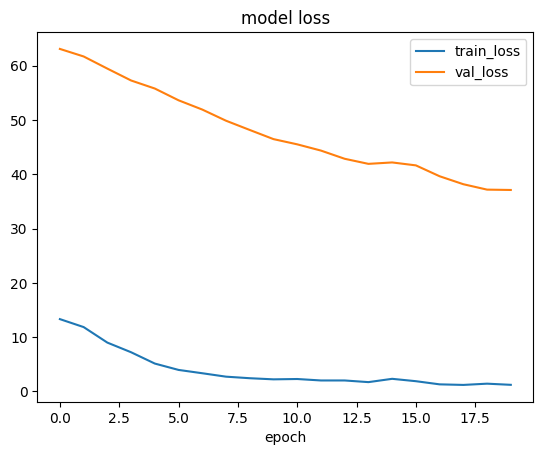

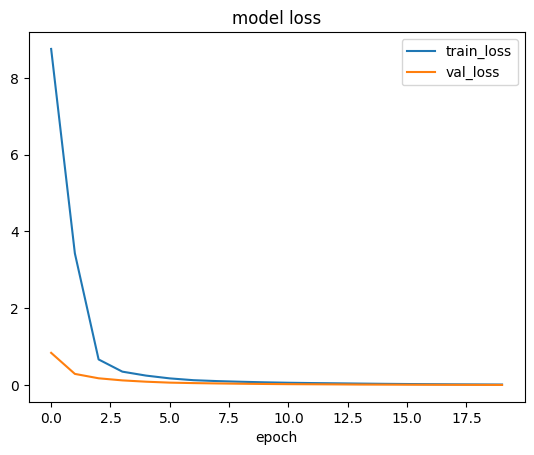

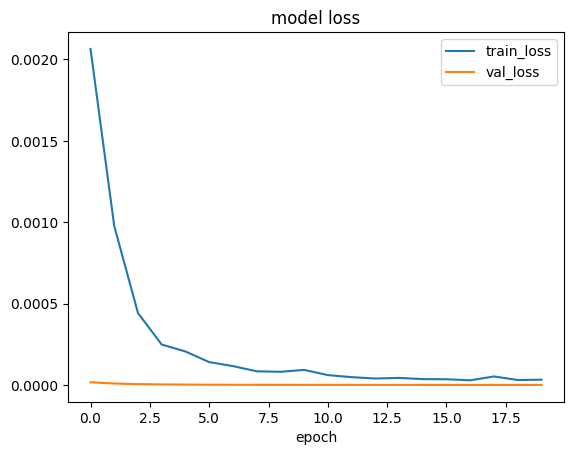

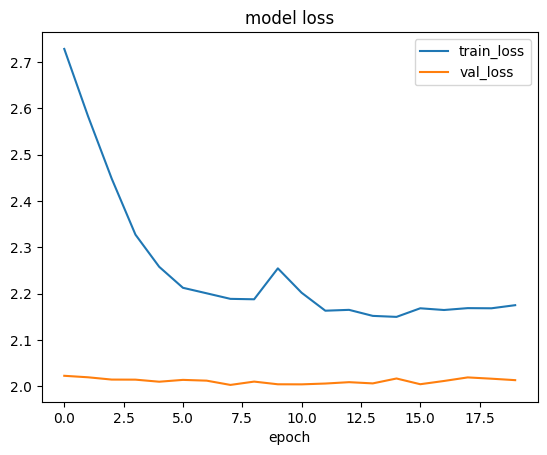

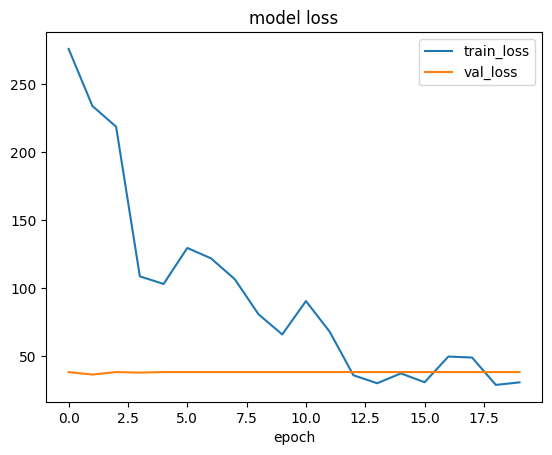

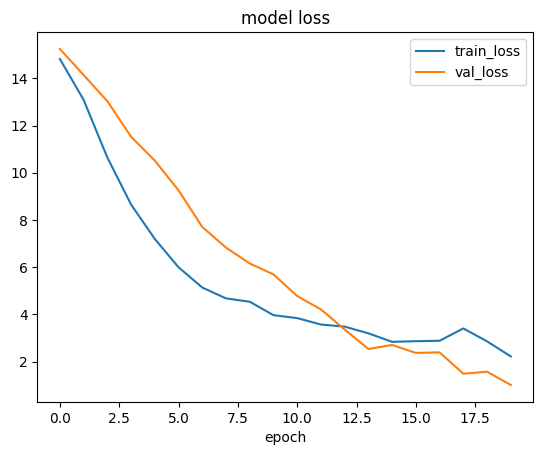

In [ ]:
#測試訓練好的神經網路
test_np_array = np.array([[36.6e3, 112e-6, 281.3e-6]])
print(type(test_np_array))
loss_of_cap = model_cl.predict(test_np_array) # Change input to 2D array
print(f"loss of cap:{loss_of_cap}")

loss_of_sw_h = model_sw_h.predict(test_np_array) # Change input to 2D array
print(f"loss of high side　switch:{loss_of_sw_h}")

loss_of_sw_l = model_sw_l.predict(test_np_array) # Change input to 2D array
print(f"loss of low side　switch:{loss_of_sw_l}")

loss_of_inductor_cu = model_indl_cu.predict(test_np_array) # Change input to 2D array
print(f"copper loss of inductor:{loss_of_inductor_cu}")

ripple_v = model_ripple_v.predict(test_np_array) # Change input to 2D array
print(f"voltage ripple:{ripple_v}")

ripple_c = model_ripple_c.predict(test_np_array) # Change input to 2D array
print(f"curent ripple:{ripple_c}")

# print(history_sw_h.history.keys()) #查詢key值
#plot trian set and validation set a.accurate b.loss
def print_history(history):
  # plt.plot(history.history['accuracy'])
  # plt.plot(history.history['val_accuracy'])
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

print_history(history_sw_h)
print_history(history_sw_l)
print_history(history_cl)
print_history(history_ripple_v)
print_history(history_ripple_c)
print_history(history_indl_cu)

In [ ]:
#access database to get capacitor and inductor database
#產生開關頻率 20kHz ~ 200kHz (step 0.1k Hz)
fsw = []
fsw_max = 200e3
fsw_min = 20e3
fsw_temp= fsw_min
while True:
    if fsw_temp > fsw_max:
        break
    fsw.append(fsw_temp)
    fsw_temp += 100

#產生電感值 Lmin = 30uH Lmax = 2mH
ind = []
ind_table = pd.read_csv("/content/data/ind_table.csv", names=["part_no","value","ESR","ind_N","volume"])
#選擇存成list格式的特定行
selected_colums = ['value','volume','part_no','ind_N','ESR']
#將選擇的行存到list中
list_of_selected_columns = [ind_table[column].tolist() for column in selected_colums]

# print(list_of_selected_columns)
#去除標題
list_of_value_ind = list_of_selected_columns[0]
list_of_value_ind.pop(0)
list_of_volume_ind = list_of_selected_columns[1]
list_of_volume_ind.pop(0)
list_of_part_no_ind = list_of_selected_columns[2]
list_of_part_no_ind.pop(0)
list_of_ind_N = list_of_selected_columns[3]
list_of_ind_N.pop(0)
list_of_ESR_ind = list_of_selected_columns[4]
list_of_ESR_ind.pop(0)
#save inductance to ind[]
float_ind_value_list = [float(item)*1e-6 for item in list_of_value_ind]
ind = float_ind_value_list

#從lookup table取得電容值 Cmin = 20uF Cmax = 1000uF
cap = []
#讀取cap_table 並且儲存[[cap_v1, cap_v2 ...] [cap_volume1, cap_volume2 ...] [part_no_1, part_no_2 ...]]
#讀取下來的資料為pandas dataframe格式
cap_table = pd.read_csv("/content/data/cap_table.csv", names=["part_no","value","volume","ESR","ESL"])
#選擇存成list格式的特定行
selected_colums = ['value','volume','part_no','ESR','ESL']
#將選擇的行存到list中
list_of_selected_columns = [cap_table[column].tolist() for column in selected_colums]

# print(list_of_selected_columns)
#去除標題
list_of_value_cap = list_of_selected_columns[0]
list_of_value_cap.pop(0)
list_of_volume_cap = list_of_selected_columns[1]
list_of_volume_cap.pop(0)
list_of_part_no_cap = list_of_selected_columns[2]
list_of_part_no_cap.pop(0)
list_of_ESR_cap = list_of_selected_columns[3]
list_of_ESR_cap.pop(0)
list_of_ESL_cap = list_of_selected_columns[4]
list_of_ESL_cap.pop(0)

#save capacitance to cap[]
float_cap_value_list = [float(item)*1e-6 for item in list_of_value_cap]
cap = float_cap_value_list

#Genetic algorithm

#store oi result for each generation
oi = []
#xi is a small constant
xi = 0.00001
#volume limit (cm^3) / ripple limit unit(%)
vol_lim = 7.0
ripple_v_lim = 1
ripple_c_lim = 10
#capacitor and inductor volume from database

#fitness_func 有三個輸入變數1. the instance of the pygad.GA class 2.single solution(gene) 3.its index in the population
def fitness_func(ga_instance, solution, solution_idx):
    #使用神經網路計算1.損耗 2.輸出電壓漣波 3.輸出電流漣波 4.規格表查元件體積
    #計算所有個體的目標值
    #找出最大的目標值存為Omax
    #找出最小的目標值存為Omin
    #計算fitness函數
    omax = max(oi)
    omin = min(oi)
    fitness = (omax - oi[solution_idx])/(omax - omin) + xi
    # change fitness from ndarray to float ??
    fitness = fitness[0]
    print(f"Fitness : {fitness}")
    return fitness

def on_start(ga_instance):
    global oi
    oi = []
    print(f"Generation = {ga_instance.generations_completed}")

    for idx in range(ga_instance.population.shape[0]):
        solution = ga_instance.population[idx]
        # print(f"index = {idx} Solution = {solution}")
        # calculate total loss of each solutions

        solution = np.array([solution])
        print(f"solution test:{solution[0]}")
        # find vol_l and vol_c
        solution_list = solution.tolist()
        vol_c = float(list_of_volume_cap[float_cap_value_list.index(solution_list[0][1])])
        vol_l = float(list_of_volume_ind[float_ind_value_list.index(solution_list[0][2])])

        print(f"vol_l = {vol_l} vol_c = {vol_c}")

        loss_of_cap = model_cl.predict(solution)
        loss_of_sw_h = model_sw_h.predict(solution)
        loss_of_sw_l = model_sw_l.predict(solution)
        loss_of_inductor_cu = model_indl_cu.predict(solution)
        ripple_v = model_ripple_v.predict(solution)
        ripple_c = model_ripple_c.predict(solution)
        power_loss_total = loss_of_cap + loss_of_sw_h + loss_of_sw_l + loss_of_inductor_cu
        oi.append(power_loss_total + max(0 , ((vol_l + vol_c)/vol_lim - 1)) + max(0, ((ripple_v / ripple_v_lim) - 1)) + max(0, ((ripple_c / ripple_c_lim) - 1)))

def on_generation(ga_instance):
    global oi
    oi.clear()
    print(f"Generation = {ga_instance.generations_completed}")

    for idx in range(ga_instance.population.shape[0]):
        solution = ga_instance.population[idx]
        print(f"index = {idx} Solution = {solution}")
        solution = np.array([solution])
        print(f"solution test:{solution[0]}")
        # find vol_l and vol_c
        solution_list = solution.tolist()
        vol_c = float(list_of_volume_cap[float_cap_value_list.index(solution_list[0][1])])
        vol_l = float(list_of_volume_ind[float_ind_value_list.index(solution_list[0][2])])

        print(f"vol_l = {vol_l} vol_c = {vol_c}")

        loss_of_cap = model_cl.predict(solution)
        loss_of_sw_h = model_sw_h.predict(solution)
        loss_of_sw_l = model_sw_l.predict(solution)
        loss_of_inductor_cu = model_indl_cu.predict(solution)
        ripple_v = model_ripple_v.predict(solution)
        ripple_c = model_ripple_c.predict(solution)
        power_loss_total = loss_of_cap + loss_of_sw_h + loss_of_sw_l + loss_of_inductor_cu
        oi.append(power_loss_total + max(0 , (vol_l + (vol_c)/vol_lim - 1)) + max(0, ((ripple_v / ripple_v_lim) - 1)) + max(0, ((ripple_c / ripple_c_lim) - 1)))

#基因演算法 可調整參數
fitness_function = fitness_func
#演化代數
num_generations = 50
#Number of solutions to be selected as parents
num_parents_mating = 4

#有幾個個體
sol_per_pop = 8

#基因初始值上下限 (改為使用gene_space限制基因的範圍) fsw C L
gene_space = [fsw, cap, ind]

#每個個體有幾個基因(三個fc L C)
num_genes = len(gene_space)


#roulette wheel selection
parent_selection_type = "rws"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_num_genes = 1

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_num_genes=mutation_num_genes,
                       on_start = on_start,
                       gene_space = gene_space,
                       on_generation = on_generation,
                       mutation_by_replacement=True)

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))



Generation = 0
solution test:[8.03000000e+04 9.74059406e-04 2.32500000e-04]
vol_l = 6.305 vol_c = 7.351
1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1/1 [==============================] - 0s 18ms/step
solution test:[1.86300000e+05 9.16428571e-04 1.00328000e-03]
vol_l = 9.489 vol_c = 7.333
1/1 [==============================] - 0s 17ms/step
solution test:[7.32000000e+04 4.16039604e-04 8.90600000e-05]
vol_l = 2.034 vol_c = 4.838
1/1 [==============================] - 0s 17ms/step
solution test:[1.22700000e+05 7.75652174e-04 1.99066000e-03]
vol_l = 12.849 vol_c = 6.209
1/1 [==============================] - 0s 22ms/step
solution test:[1.24000000e+05 8.53461538e-04 5.36380000e-04]
vol_l = 9.489 vol_c = 4.112
1/1 [==============================] - 0s 18ms/step
solution test:[1.7160e+05 3.0000e-04 2.4189e-04]
vol_l = 6.305 vol_c = 5.216
1/1 [==============================] - 0s 24ms/step
solution test:[1.13800000e+05 6.44350993e-04 1.42886000e-03]
vol_l = 12.849 vol_c = 6.475
1/1 [==============================] - 0s 18ms/step
solution test:[1.03800000e+05 4.11860465e-04 1.80050000e-04]
vol_l = 6.305 vol_c = 4.224
1/1 [==================

In [ ]:
#印出使用元件
solution_list = solution.tolist()
# print(type(solution_list))
# print(type(solution_list[1]))
# print(type(solution_list[2]))
# print(solution_list[1])
index_cap = float_cap_value_list.index(solution_list[1])
esr_cap = float(list_of_ESR_cap[float_cap_value_list.index(solution_list[1])])/float(solution_list[0])
esl_cap = list_of_ESL_cap[float_cap_value_list.index(solution_list[1])]
index_ind = float_ind_value_list.index(solution_list[2])
esr_ind = list_of_ESR_ind[float_ind_value_list.index(solution_list[2])]
vol_c = list_of_volume_cap[float_cap_value_list.index(solution_list[1])]
vol_l = list_of_volume_ind[float_ind_value_list.index(solution_list[2])]
part_no_cap = list_of_part_no_cap[float_cap_value_list.index(solution_list[1])]
part_no_ind = list_of_part_no_ind[float_ind_value_list.index(solution_list[2])]
ind_N = list_of_ind_N[float_ind_value_list.index(solution_list[2])]
print("Capacitor part number : {part_no_cap}".format(part_no_cap = part_no_cap))
print("Capacitor ESR : {esr_cap}".format(esr_cap = esr_cap))
print("Capacitor ESL : {esl_cap}".format(esl_cap = esl_cap))
print("Capacitor volume : {vol_c}".format(vol_c = vol_c))
print("Inductor part number : {part_no_ind}".format(part_no_ind = part_no_ind))
print("Inductor turn number : {ind_N}".format(ind_N = ind_N))
print("Inductor ESR : {esr_ind}".format(esr_ind = esr_ind))
print("Inductor volume : {vol_l}".format(vol_l = vol_l))

#最佳解預測
test_np_array = np.array([solution_list])
loss_of_cap = model_cl.predict(test_np_array) # Change input to 2D array
print(f"loss of cap:{loss_of_cap}")

loss_of_sw_h = model_sw_h.predict(test_np_array) # Change input to 2D array
print(f"loss of high side　switch:{loss_of_sw_h}")

loss_of_sw_l = model_sw_l.predict(test_np_array) # Change input to 2D array
print(f"loss of low side　switch:{loss_of_sw_l}")

loss_of_inductor_cu = model_indl_cu.predict(test_np_array) # Change input to 2D array
print(f"copper loss of inductor:{loss_of_inductor_cu}")

ripple_v = model_ripple_v.predict(test_np_array) # Change input to 2D array
print(f"voltage ripple:{ripple_v}")

ripple_c = model_ripple_c.predict(test_np_array) # Change input to 2D array
print(f"curent ripple:{ripple_c}")

Capacitor part number : EKZE250Exx182MK30S+EKZE250Exx221MHB5D/EKZE250Exx221MHB5D
Capacitor ESR : 0.000731648374349256
Capacitor ESL : 1.055e-07
Capacitor volume : 4.838
Inductor part number : T80-75-200
Inductor turn number : 44
Inductor ESR : 0.019114
Inductor volume : 2.034
1/1 [==============================] - 0s 26ms/step
loss of cap:[[2.0046422]]
1/1 [==============================] - 0s 29ms/step
loss of high side　switch:[[0.5501653]]
1/1 [==============================] - 0s 17ms/step
loss of low side　switch:[[0.00021505]]
1/1 [==============================] - 0s 18ms/step
copper loss of inductor:[[4.0194893e-05]]
1/1 [==============================] - 0s 19ms/step
voltage ripple:[[0.03147464]]
1/1 [==============================] - 0s 19ms/step
curent ripple:[[0.]]
